In [362]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

This notebook reads the data in pdiot_data/2021, removes recordings that are too small, and creates sliding windows of the recordings. These are then saved into ../data/sliding_windows_sizeX_stepX

## Getting the data

In [433]:
data_path = '../pdiot-data/2021/'
sensor='Respeck'
# set this to 0 to produce sliding windows with no smoothing
# smoothing_window = 0
smoothing_window = 7

In [381]:
def get_base_df(sensor):
    base_df = pd.DataFrame()

    # Get a list of all respeck files in all the student folders
    all_files = []
    for f in os.listdir(data_path):
        if os.path.isdir(data_path + '/' + f):
            files = os.listdir(data_path + '/' + f)
            files = [data_path + '/' + f + '/' + f2 for f2 in files if sensor in f2]
            all_files += files
    
    # Load them all into a df
    for filename in all_files:
        #full_path = f"{clean_data_folder}/{filename}"
        #print(full_path)

        # load data into a DataFrame
        new_df = pd.read_csv(filename)

        # merge into the base DataFrame
        base_df = pd.concat([base_df, new_df])
        
    return base_df

base_df = get_base_df(sensor)

In [382]:
# We want to remove any falling recordings over 700 datapoints as this suggests that it contains falling + getting up
# We also want to remove any recordings less than the window size

In [383]:
smallest_window_size = 25
s = base_df.groupby('recording_id').size() >= smallest_window_size

filtered_df = base_df[base_df['recording_id'].isin(s.keys()[s])]

# One Thingy recording has a bunch of NAN
filtered_df = filtered_df[filtered_df['recording_id'] != 'Thingy_s1817455_Falling on the left_29-09-2021_16-13-56']

# Remove falling recordings longer than 700
s = filtered_df[filtered_df['activity_type'].str.contains('Falling')].groupby('recording_id').size() >= 700

filtered_df = filtered_df[~filtered_df['recording_id'].isin(s.keys()[s])]

# s1702583 has really inconsistent activity naming - remove
filtered_df = filtered_df[filtered_df['subject_id'] != 's1702583']

In [384]:
# Check that other people named correctly
filtered_df[filtered_df.apply(lambda x: not(x.activity_type in x.recording_id or x.activity_type.replace(' ', '_') in x.recording_id), axis=1)]

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,sensor_type,activity_type,activity_code,subject_id,notes,recording_id


In [385]:
# drop unnecessary columns
filtered_df.drop(columns=['notes'], inplace=True)
if sensor == 'Thingy':
    filtered_df.drop(columns=['Unnamed: 0'], inplace=True)

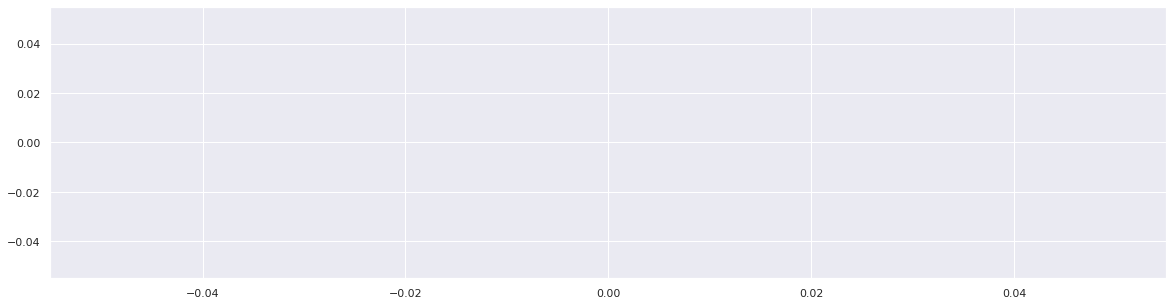

In [386]:
def plot_by_id(i): 
    plot_recording = base_df[base_df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
    
plot_by_id('Thingy_s1817455_Falling on the left_29-09-2021_16-13-56')

/home/sonia/miniconda3/envs/pdiot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


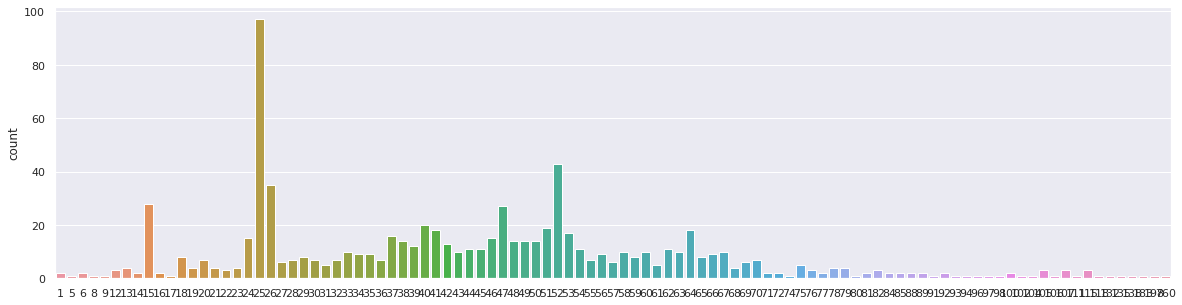

In [387]:
#base_df[base_df['activity_type'] == "Falling on the back"].groupby('recording_id').size().sort_values().head(40)
#base_df.groupby('recording_id').size().sort_values().head(100)
from collections import Counter
#Counter(base_df[base_df['activity_type'] == "Falling on the back"].groupby('recording_id').size().sort_values())
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.countplot(base_df[base_df['activity_type'] == "Falling on knees"].groupby('recording_id').size().sort_values())

In [388]:
filtered_df.groupby('activity_type').size().sort_values()

activity_type
Falling on the left        33964
Falling on the right       34025
Falling on knees           34317
Falling on the back        34336
Running                    35294
Walking at normal speed    35367
Climbing stairs            35401
Sitting                    35895
Sitting bent backward      35948
Standing                   35981
Sitting bent forward       35998
Lying down right           36066
Desk work                  36085
Lying down left            36133
Movement                   36149
Descending stairs          36202
Lying down on back         36313
Lying down on stomach      36425
dtype: int64

## Smoothing the filtered_df

In [406]:
if smoothing_window > 0:
    smoothed_df = pd.DataFrame(columns=filtered_df.columns)
    for rec_id, group in filtered_df.groupby('recording_id'):
        win_size = smoothing_window
        win_type = 'hamming'
        center = True

        group['new_accel_x'] = group['accel_x'].rolling(window=win_size, win_type=win_type, center=center).mean()
        group['new_accel_y'] = group['accel_y'].rolling(window=win_size, win_type=win_type, center=center).mean()
        group['new_accel_z'] = group['accel_z'].rolling(window=win_size, win_type=win_type, center=center).mean()
        group['new_gyro_x'] = group['gyro_x'].rolling(window=win_size, win_type=win_type, center=center).mean()
        group['new_gyro_y'] = group['gyro_y'].rolling(window=win_size, win_type=win_type, center=center).mean()
        group['new_gyro_z'] = group['gyro_z'].rolling(window=win_size, win_type=win_type, center=center).mean()

        group.drop(columns=['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z'], inplace=True)
        group.rename(columns={'new_accel_x':'accel_x','new_accel_y':'accel_y','new_accel_z':'accel_z','new_gyro_x':'gyro_x','new_gyro_y':'gyro_y','new_gyro_z':'gyro_z' }, inplace=True)

        smoothed_df = pd.concat([smoothed_df, group], ignore_index=True)
        print(rec_id)

    # Remove any rows with NaNs (at beginning and end of recording due to smoothing)
    smoothed_df.dropna(subset=['accel_x'], inplace=True)
    smoothed_df = smoothed_df.reset_index(drop=True)

    smoothed_df

Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43
Respeck_s1541031_Descending stairs_06-10-2021_11-25-05
Respeck_s1541031_Desk work_06-10-2021_11-04-49
Respeck_s1541031_Falling on knees_06-10-2021_15-46-44
Respeck_s1541031_Falling on knees_06-10-2021_15-47-02
Respeck_s1541031_Falling on knees_06-10-2021_15-47-13
Respeck_s1541031_Falling on knees_06-10-2021_15-47-20
Respeck_s1541031_Falling on knees_06-10-2021_15-47-25
Respeck_s1541031_Falling on knees_06-10-2021_15-47-30
Respeck_s1541031_Falling on knees_06-10-2021_15-47-35
Respeck_s1541031_Falling on knees_06-10-2021_15-47-39
Respeck_s1541031_Falling on knees_06-10-2021_15-47-44
Respeck_s1541031_Falling on knees_06-10-2021_15-47-48
Respeck_s1541031_Falling on knees_06-10-2021_15-47-52
Respeck_s1541031_Falling on knees_06-10-2021_15-47-56
Respeck_s1541031_Falling on knees_06-10-2021_15-48-10
Respeck_s1541031_Falling on knees_06-10-2021_15-48-17
Respeck_s1541031_Falling on knees_06-10-2021_15-48-23
Respeck_s1541031_Falling on knees_0

Respeck_s1706154_Falling on knees_06-10-2021_12-39-35
Respeck_s1706154_Falling on knees_06-10-2021_12-39-38
Respeck_s1706154_Falling on knees_06-10-2021_12-39-41
Respeck_s1706154_Falling on knees_06-10-2021_12-39-44
Respeck_s1706154_Falling on knees_06-10-2021_12-39-46
Respeck_s1706154_Falling on the back_06-10-2021_12-51-04
Respeck_s1706154_Falling on the back_06-10-2021_12-51-08
Respeck_s1706154_Falling on the back_06-10-2021_12-51-11
Respeck_s1706154_Falling on the back_06-10-2021_12-51-15
Respeck_s1706154_Falling on the back_06-10-2021_12-51-18
Respeck_s1706154_Falling on the back_06-10-2021_12-51-22
Respeck_s1706154_Falling on the back_06-10-2021_12-51-26
Respeck_s1706154_Falling on the back_06-10-2021_12-51-31
Respeck_s1706154_Falling on the back_06-10-2021_12-51-34
Respeck_s1706154_Falling on the back_06-10-2021_12-51-38
Respeck_s1706154_Falling on the back_06-10-2021_12-51-43
Respeck_s1706154_Falling on the back_06-10-2021_12-51-45
Respeck_s1706154_Falling on the back_06-10-202

Respeck_s1721256_Falling on knees_02-10-2021_21-40-23
Respeck_s1721256_Falling on knees_02-10-2021_21-45-18
Respeck_s1721256_Falling on knees_02-10-2021_21-45-25
Respeck_s1721256_Falling on knees_02-10-2021_21-45-33
Respeck_s1721256_Falling on knees_02-10-2021_21-45-41
Respeck_s1721256_Falling on knees_02-10-2021_21-45-56
Respeck_s1721256_Falling on knees_02-10-2021_21-46-03
Respeck_s1721256_Falling on knees_02-10-2021_21-46-09
Respeck_s1721256_Falling on the back_02-10-2021_21-41-12
Respeck_s1721256_Falling on the back_02-10-2021_21-41-18
Respeck_s1721256_Falling on the back_02-10-2021_21-41-24
Respeck_s1721256_Falling on the back_02-10-2021_21-41-30
Respeck_s1721256_Falling on the back_02-10-2021_21-41-36
Respeck_s1721256_Falling on the back_02-10-2021_21-41-42
Respeck_s1721256_Falling on the back_02-10-2021_21-41-48
Respeck_s1721256_Falling on the back_02-10-2021_21-41-54
Respeck_s1721256_Falling on the back_02-10-2021_21-46-36
Respeck_s1721256_Falling on the back_02-10-2021_21-46-4

Respeck_s1724067_Falling on the left_06-10-2021_18-39-36
Respeck_s1724067_Falling on the left_06-10-2021_18-39-47
Respeck_s1724067_Falling on the left_06-10-2021_18-40-00
Respeck_s1724067_Falling on the left_06-10-2021_18-40-09
Respeck_s1724067_Falling on the left_06-10-2021_18-40-18
Respeck_s1724067_Falling on the left_06-10-2021_18-40-29
Respeck_s1724067_Falling on the left_06-10-2021_18-40-47
Respeck_s1724067_Falling on the left_06-10-2021_18-40-57
Respeck_s1724067_Falling on the left_06-10-2021_18-41-09
Respeck_s1724067_Falling on the left_06-10-2021_18-41-20
Respeck_s1724067_Falling on the left_06-10-2021_18-41-44
Respeck_s1724067_Falling on the right_06-10-2021_18-46-23
Respeck_s1724067_Falling on the right_06-10-2021_18-46-31
Respeck_s1724067_Falling on the right_06-10-2021_18-46-39
Respeck_s1724067_Falling on the right_06-10-2021_18-46-48
Respeck_s1724067_Falling on the right_06-10-2021_18-46-56
Respeck_s1724067_Falling on the right_06-10-2021_18-47-05
Respeck_s1724067_Falling 

Respeck_s1727780_Falling on the left_29-09-2021_21-53-29
Respeck_s1727780_Falling on the left_29-09-2021_21-53-36
Respeck_s1727780_Falling on the left_29-09-2021_21-53-45
Respeck_s1727780_Falling on the left_29-09-2021_21-54-03
Respeck_s1727780_Falling on the left_29-09-2021_21-54-12
Respeck_s1727780_Falling on the left_29-09-2021_21-54-20
Respeck_s1727780_Falling on the left_29-09-2021_21-54-29
Respeck_s1727780_Falling on the left_29-09-2021_21-54-37
Respeck_s1727780_Falling on the left_29-09-2021_21-54-49
Respeck_s1727780_Falling on the right_29-09-2021_21-55-15
Respeck_s1727780_Falling on the right_29-09-2021_21-55-22
Respeck_s1727780_Falling on the right_29-09-2021_21-55-30
Respeck_s1727780_Falling on the right_29-09-2021_21-55-38
Respeck_s1727780_Falling on the right_29-09-2021_21-55-48
Respeck_s1727780_Falling on the right_29-09-2021_21-55-56
Respeck_s1727780_Falling on the right_29-09-2021_21-56-03
Respeck_s1727780_Falling on the right_29-09-2021_21-56-12
Respeck_s1727780_Fallin

Respeck_s1757177_Falling on the back_02-10-2021_20-05-37
Respeck_s1757177_Falling on the back_02-10-2021_20-05-41
Respeck_s1757177_Falling on the left_02-10-2021_20-01-59
Respeck_s1757177_Falling on the left_02-10-2021_20-02-08
Respeck_s1757177_Falling on the left_02-10-2021_20-02-12
Respeck_s1757177_Falling on the left_02-10-2021_20-02-17
Respeck_s1757177_Falling on the left_02-10-2021_20-02-22
Respeck_s1757177_Falling on the left_02-10-2021_20-02-27
Respeck_s1757177_Falling on the left_02-10-2021_20-02-33
Respeck_s1757177_Falling on the left_02-10-2021_20-02-37
Respeck_s1757177_Falling on the left_02-10-2021_20-02-41
Respeck_s1757177_Falling on the left_02-10-2021_20-02-45
Respeck_s1757177_Falling on the right_02-10-2021_20-03-39
Respeck_s1757177_Falling on the right_02-10-2021_20-03-45
Respeck_s1757177_Falling on the right_02-10-2021_20-03-48
Respeck_s1757177_Falling on the right_02-10-2021_20-03-53
Respeck_s1757177_Falling on the right_02-10-2021_20-03-57
Respeck_s1757177_Falling o

Respeck_s1800883_Falling on the right_29-09-2021_14-28-28
Respeck_s1800883_Falling on the right_29-09-2021_14-28-34
Respeck_s1800883_Falling on the right_29-09-2021_14-28-41
Respeck_s1800883_Falling on the right_29-09-2021_14-28-47
Respeck_s1800883_Falling on the right_29-09-2021_14-29-41
Respeck_s1800883_Falling on the right_29-09-2021_14-29-48
Respeck_s1800883_Falling on the right_29-09-2021_14-29-54
Respeck_s1800883_Falling on the right_29-09-2021_14-30-00
Respeck_s1800883_Falling on the right_29-09-2021_14-30-06
Respeck_s1800883_Falling on the right_29-09-2021_14-30-11
Respeck_s1800883_Falling on the right_29-09-2021_14-30-17
Respeck_s1800883_Falling on the right_29-09-2021_14-30-23
Respeck_s1800883_Falling on the right_29-09-2021_14-30-29
Respeck_s1800883_Falling on the right_29-09-2021_14-30-35
Respeck_s1800883_Lying down left_29-09-2021_13-40-06
Respeck_s1800883_Lying down on back_29-09-2021_13-38-01
Respeck_s1800883_Lying down on stomach_29-09-2021_13-39-15
Respeck_s1800883_Lyi

Respeck_s1813106_Falling on the left_07-10-2021_13-25-16
Respeck_s1813106_Falling on the left_07-10-2021_13-25-22
Respeck_s1813106_Falling on the left_07-10-2021_13-25-32
Respeck_s1813106_Falling on the left_07-10-2021_13-25-37
Respeck_s1813106_Falling on the left_07-10-2021_13-25-42
Respeck_s1813106_Falling on the right_07-10-2021_13-19-58
Respeck_s1813106_Falling on the right_07-10-2021_13-20-04
Respeck_s1813106_Falling on the right_07-10-2021_13-20-09
Respeck_s1813106_Falling on the right_07-10-2021_13-20-19
Respeck_s1813106_Falling on the right_07-10-2021_13-20-26
Respeck_s1813106_Falling on the right_07-10-2021_13-20-30
Respeck_s1813106_Falling on the right_07-10-2021_13-20-45
Respeck_s1813106_Falling on the right_07-10-2021_13-20-55
Respeck_s1813106_Falling on the right_07-10-2021_13-21-04
Respeck_s1813106_Falling on the right_07-10-2021_13-21-09
Respeck_s1813106_Falling on the right_07-10-2021_13-21-19
Respeck_s1813106_Falling on the right_07-10-2021_13-21-24
Respeck_s1813106_Fa

Respeck_s1817972_Falling on the left_05-10-2021_11-41-18
Respeck_s1817972_Falling on the left_05-10-2021_11-41-30
Respeck_s1817972_Falling on the left_05-10-2021_11-41-34
Respeck_s1817972_Falling on the left_05-10-2021_11-41-42
Respeck_s1817972_Falling on the left_05-10-2021_11-41-47
Respeck_s1817972_Falling on the left_05-10-2021_11-41-50
Respeck_s1817972_Falling on the left_05-10-2021_11-41-55
Respeck_s1817972_Falling on the left_05-10-2021_11-41-59
Respeck_s1817972_Falling on the left_05-10-2021_11-42-05
Respeck_s1817972_Falling on the right_05-10-2021_11-44-46
Respeck_s1817972_Falling on the right_05-10-2021_11-44-50
Respeck_s1817972_Falling on the right_05-10-2021_11-44-57
Respeck_s1817972_Falling on the right_05-10-2021_11-45-01
Respeck_s1817972_Falling on the right_05-10-2021_11-45-05
Respeck_s1817972_Falling on the right_05-10-2021_11-45-08
Respeck_s1817972_Falling on the right_05-10-2021_11-45-13
Respeck_s1817972_Falling on the right_05-10-2021_11-45-17
Respeck_s1817972_Fallin

Respeck_s1823274_Falling on the left_04-10-2021_15-56-49
Respeck_s1823274_Falling on the left_04-10-2021_15-57-01
Respeck_s1823274_Falling on the left_04-10-2021_15-57-12
Respeck_s1823274_Falling on the left_04-10-2021_15-57-23
Respeck_s1823274_Falling on the left_04-10-2021_15-57-35
Respeck_s1823274_Falling on the left_04-10-2021_15-57-46
Respeck_s1823274_Falling on the left_04-10-2021_15-57-59
Respeck_s1823274_Falling on the right_04-10-2021_15-58-54
Respeck_s1823274_Falling on the right_04-10-2021_15-59-04
Respeck_s1823274_Falling on the right_04-10-2021_15-59-15
Respeck_s1823274_Falling on the right_04-10-2021_15-59-27
Respeck_s1823274_Falling on the right_04-10-2021_15-59-39
Respeck_s1823274_Falling on the right_04-10-2021_15-59-50
Respeck_s1823274_Falling on the right_04-10-2021_16-00-02
Respeck_s1823274_Falling on the right_04-10-2021_16-00-12
Respeck_s1823274_Falling on the right_04-10-2021_16-00-24
Respeck_s1823274_Falling on the right_04-10-2021_16-00-36
Respeck_s1823274_Fall

Respeck_s1826390_Falling on the left_08-10-2021_00-29-59
Respeck_s1826390_Falling on the right_08-10-2021_00-53-15
Respeck_s1826390_Falling on the right_08-10-2021_00-53-26
Respeck_s1826390_Falling on the right_08-10-2021_00-54-23
Respeck_s1826390_Falling on the right_08-10-2021_00-54-34
Respeck_s1826390_Falling on the right_08-10-2021_00-54-41
Respeck_s1826390_Falling on the right_08-10-2021_00-54-45
Respeck_s1826390_Falling on the right_08-10-2021_00-54-52
Respeck_s1826390_Falling on the right_08-10-2021_00-54-57
Respeck_s1826390_Falling on the right_08-10-2021_00-55-03
Respeck_s1826390_Falling on the right_08-10-2021_00-55-14
Respeck_s1826390_Falling on the right_08-10-2021_00-55-39
Respeck_s1826390_Falling on the right_08-10-2021_00-55-46
Respeck_s1826390_Lying down left_07-10-2021_01-39-23
Respeck_s1826390_Lying down on back_07-10-2021_01-34-01
Respeck_s1826390_Lying down on stomach_07-10-2021_02-07-31
Respeck_s1826390_Lying down right_07-10-2021_01-42-02
Respeck_s1826390_Movement

Respeck_s1842093_Falling on the right_05-10-2021_21-33-06
Respeck_s1842093_Falling on the right_05-10-2021_21-33-14
Respeck_s1842093_Falling on the right_05-10-2021_21-33-21
Respeck_s1842093_Falling on the right_05-10-2021_21-33-27
Respeck_s1842093_Falling on the right_05-10-2021_21-33-49
Respeck_s1842093_Falling on the right_05-10-2021_21-33-56
Respeck_s1842093_Falling on the right_05-10-2021_21-34-02
Respeck_s1842093_Falling on the right_05-10-2021_21-34-13
Respeck_s1842093_Falling on the right_05-10-2021_21-34-25
Respeck_s1842093_Falling on the right_05-10-2021_21-34-33
Respeck_s1842093_Falling on the right_05-10-2021_21-34-40
Respeck_s1842093_Falling on the right_05-10-2021_21-34-47
Respeck_s1842093_Falling on the right_05-10-2021_21-35-37
Respeck_s1842093_Falling on the right_05-10-2021_21-35-44
Respeck_s1842093_Falling on the right_05-10-2021_21-35-51
Respeck_s1842093_Falling on the right_05-10-2021_21-35-59
Respeck_s1842093_Lying down left_05-10-2021_18-15-43
Respeck_s1842093_Ly

Respeck_s1864705_Falling on knees_06-10-2021_23-05-13
Respeck_s1864705_Falling on knees_06-10-2021_23-05-16
Respeck_s1864705_Falling on knees_06-10-2021_23-05-19
Respeck_s1864705_Falling on knees_06-10-2021_23-05-22
Respeck_s1864705_Falling on knees_06-10-2021_23-05-35
Respeck_s1864705_Falling on knees_06-10-2021_23-05-37
Respeck_s1864705_Falling on knees_06-10-2021_23-05-41
Respeck_s1864705_Falling on knees_06-10-2021_23-05-44
Respeck_s1864705_Falling on knees_06-10-2021_23-05-50
Respeck_s1864705_Falling on knees_06-10-2021_23-05-53
Respeck_s1864705_Falling on knees_06-10-2021_23-05-56
Respeck_s1864705_Falling on knees_06-10-2021_23-05-59
Respeck_s1864705_Falling on knees_06-10-2021_23-06-02
Respeck_s1864705_Falling on knees_06-10-2021_23-06-07
Respeck_s1864705_Falling on knees_06-10-2021_23-06-10
Respeck_s1864705_Falling on knees_06-10-2021_23-06-13
Respeck_s1864705_Falling on knees_06-10-2021_23-06-16
Respeck_s1864705_Falling on knees_06-10-2021_23-06-25
Respeck_s1864705_Falling on 

Respeck_s1865457_Falling on the left_30-09-2021_11-55-23
Respeck_s1865457_Falling on the left_30-09-2021_11-55-27
Respeck_s1865457_Falling on the left_30-09-2021_11-55-32
Respeck_s1865457_Falling on the left_30-09-2021_11-55-37
Respeck_s1865457_Falling on the left_30-09-2021_11-55-47
Respeck_s1865457_Falling on the left_30-09-2021_11-55-52
Respeck_s1865457_Falling on the left_30-09-2021_11-55-58
Respeck_s1865457_Falling on the left_30-09-2021_11-56-07
Respeck_s1865457_Falling on the left_30-09-2021_11-56-13
Respeck_s1865457_Falling on the left_30-09-2021_11-56-18
Respeck_s1865457_Falling on the left_30-09-2021_11-56-23
Respeck_s1865457_Falling on the left_30-09-2021_11-56-27
Respeck_s1865457_Falling on the left_30-09-2021_11-56-32
Respeck_s1865457_Falling on the left_30-09-2021_11-56-37
Respeck_s1865457_Falling on the left_30-09-2021_11-56-42
Respeck_s1865457_Falling on the right_30-09-2021_11-58-01
Respeck_s1865457_Falling on the right_30-09-2021_11-58-08
Respeck_s1865457_Falling on t

Respeck_s1870467_Lying down left_29-09-2021_11-47-37
Respeck_s1870467_Lying down on back_29-09-2021_11-46-48
Respeck_s1870467_Lying down on stomach_29-09-2021_11-49-18
Respeck_s1870467_Lying down right_29-09-2021_11-48-27
Respeck_s1870467_Movement_29-09-2021_11-56-20
Respeck_s1870467_Running_07-10-2021_09-48-21
Respeck_s1870467_Sitting bent backward_29-09-2021_11-45-03
Respeck_s1870467_Sitting bent forward_29-09-2021_11-44-15
Respeck_s1870467_Sitting_29-09-2021_11-43-20
Respeck_s1870467_Standing_29-09-2021_11-45-59
Respeck_s1870467_Walking at normal speed_07-10-2021_09-10-03
Respeck_s1870697_Climbing stairs_04-10-2021_18-18-52
Respeck_s1870697_Climbing stairs_04-10-2021_18-19-14
Respeck_s1870697_Climbing stairs_04-10-2021_18-19-54
Respeck_s1870697_Descending stairs_04-10-2021_18-20-22
Respeck_s1870697_Descending stairs_04-10-2021_18-20-42
Respeck_s1870697_Descending stairs_04-10-2021_18-21-14
Respeck_s1870697_Desk work_04-10-2021_18-27-25
Respeck_s1870697_Falling on knees_04-10-2021_17

Respeck_s1891214_Falling on the left_07-10-2021_14-48-41
Respeck_s1891214_Falling on the right_07-10-2021_14-52-20
Respeck_s1891214_Falling on the right_07-10-2021_14-52-29
Respeck_s1891214_Falling on the right_07-10-2021_14-52-38
Respeck_s1891214_Falling on the right_07-10-2021_14-52-46
Respeck_s1891214_Falling on the right_07-10-2021_14-52-53
Respeck_s1891214_Falling on the right_07-10-2021_14-53-07
Respeck_s1891214_Falling on the right_07-10-2021_14-53-14
Respeck_s1891214_Falling on the right_07-10-2021_14-53-23
Respeck_s1891214_Falling on the right_07-10-2021_14-53-32
Respeck_s1891214_Falling on the right_07-10-2021_14-53-41
Respeck_s1891214_Falling on the right_07-10-2021_14-53-48
Respeck_s1891214_Falling on the right_07-10-2021_14-53-55
Respeck_s1891214_Falling on the right_07-10-2021_14-54-01
Respeck_s1891214_Falling on the right_07-10-2021_14-54-08
Respeck_s1891214_Falling on the right_07-10-2021_14-54-13
Respeck_s1891214_Lying down left_07-10-2021_14-20-01
Respeck_s1891214_Lyi

Respeck_s1894401_Falling on the right_01-10-2021_11-51-10
Respeck_s1894401_Falling on the right_01-10-2021_11-51-19
Respeck_s1894401_Falling on the right_01-10-2021_11-51-29
Respeck_s1894401_Falling on the right_01-10-2021_11-51-36
Respeck_s1894401_Falling on the right_01-10-2021_11-51-43
Respeck_s1894401_Falling on the right_01-10-2021_11-51-51
Respeck_s1894401_Falling on the right_01-10-2021_11-51-57
Respeck_s1894401_Lying down left_01-10-2021_12-03-57
Respeck_s1894401_Lying down on back_01-10-2021_12-03-03
Respeck_s1894401_Lying down on stomach_01-10-2021_12-01-26
Respeck_s1894401_Lying down right_01-10-2021_12-02-13
Respeck_s1894401_Movement_01-10-2021_12-00-20
Respeck_s1894401_Running_01-10-2021_12-26-11
Respeck_s1894401_Sitting bent backward_01-10-2021_12-05-48
Respeck_s1894401_Sitting bent forward_01-10-2021_12-06-36
Respeck_s1894401_Sitting_01-10-2021_12-07-25
Respeck_s1894401_Standing_01-10-2021_12-04-49
Respeck_s1894401_Walking at normal speed_01-10-2021_12-18-36
Respeck_s197

Respeck_s2119637_Falling on the left_06-10-2021_14-53-38
Respeck_s2119637_Falling on the left_06-10-2021_14-54-03
Respeck_s2119637_Falling on the left_06-10-2021_14-54-16
Respeck_s2119637_Falling on the left_06-10-2021_14-54-26
Respeck_s2119637_Falling on the left_06-10-2021_14-54-45
Respeck_s2119637_Falling on the left_06-10-2021_14-55-09
Respeck_s2119637_Falling on the right_03-10-2021_23-35-06
Respeck_s2119637_Falling on the right_06-10-2021_15-01-04
Respeck_s2119637_Falling on the right_06-10-2021_15-01-11
Respeck_s2119637_Falling on the right_06-10-2021_15-01-17
Respeck_s2119637_Falling on the right_06-10-2021_15-01-23
Respeck_s2119637_Falling on the right_06-10-2021_15-01-30
Respeck_s2119637_Falling on the right_06-10-2021_15-01-36
Respeck_s2119637_Falling on the right_06-10-2021_15-01-45
Respeck_s2119637_Falling on the right_06-10-2021_15-01-56
Respeck_s2119637_Falling on the right_06-10-2021_15-02-19
Respeck_s2119637_Falling on the right_06-10-2021_15-02-24
Respeck_s2119637_Fal

Respeck_s2171825_Falling on the left_06-10-2021_15-30-25
Respeck_s2171825_Falling on the left_06-10-2021_15-30-34
Respeck_s2171825_Falling on the right_06-10-2021_15-32-43
Respeck_s2171825_Falling on the right_06-10-2021_15-32-50
Respeck_s2171825_Falling on the right_06-10-2021_15-32-56
Respeck_s2171825_Falling on the right_06-10-2021_15-33-05
Respeck_s2171825_Falling on the right_06-10-2021_15-33-13
Respeck_s2171825_Falling on the right_06-10-2021_15-33-20
Respeck_s2171825_Falling on the right_06-10-2021_15-33-28
Respeck_s2171825_Falling on the right_06-10-2021_15-33-35
Respeck_s2171825_Falling on the right_06-10-2021_15-33-43
Respeck_s2171825_Falling on the right_06-10-2021_15-33-50
Respeck_s2171825_Falling on the right_06-10-2021_15-33-58
Respeck_s2171825_Falling on the right_06-10-2021_15-34-05
Respeck_s2171825_Falling on the right_06-10-2021_15-34-12
Respeck_s2171825_Falling on the right_06-10-2021_15-34-20
Respeck_s2171825_Falling on the right_06-10-2021_15-34-28
Respeck_s2171825

Respeck_s2173036_Falling on the right_06-10-2021_14-10-52
Respeck_s2173036_Lying down left_03-10-2021_22-42-13
Respeck_s2173036_Lying down on back_03-10-2021_22-45-15
Respeck_s2173036_Lying down on stomach_03-10-2021_22-44-21
Respeck_s2173036_Lying down right_03-10-2021_22-43-12
Respeck_s2173036_Movement_03-10-2021_22-51-01
Respeck_s2173036_Running_03-10-2021_23-04-00
Respeck_s2173036_Sitting bent backward_03-10-2021_22-38-54
Respeck_s2173036_Sitting bent forward_03-10-2021_22-37-58
Respeck_s2173036_Sitting_03-10-2021_22-36-56
Respeck_s2173036_Standing_03-10-2021_22-39-52
Respeck_s2173036_Walking at normal speed_03-10-2021_23-03-05
Respeck_s2181154_Climbing stairs_29-09-2021_14-01-56
Respeck_s2181154_Descending stairs_03-10-2021_17-46-42
Respeck_s2181154_Desk work_03-10-2021_17-48-15
Respeck_s2181154_Falling on knees_07-10-2021_19-06-28
Respeck_s2181154_Falling on knees_07-10-2021_19-06-35
Respeck_s2181154_Falling on knees_07-10-2021_19-06-40
Respeck_s2181154_Falling on knees_07-10-202

Respeck_s2192970_Falling on the left_06-10-2021_21-02-44
Respeck_s2192970_Falling on the left_06-10-2021_21-02-51
Respeck_s2192970_Falling on the left_06-10-2021_21-02-56
Respeck_s2192970_Falling on the left_06-10-2021_21-03-03
Respeck_s2192970_Falling on the left_06-10-2021_21-03-09
Respeck_s2192970_Falling on the left_06-10-2021_21-03-16
Respeck_s2192970_Falling on the left_06-10-2021_21-03-22
Respeck_s2192970_Falling on the left_06-10-2021_21-03-28
Respeck_s2192970_Falling on the left_06-10-2021_21-03-37
Respeck_s2192970_Falling on the left_06-10-2021_21-03-44
Respeck_s2192970_Falling on the left_06-10-2021_21-04-09
Respeck_s2192970_Falling on the left_06-10-2021_21-04-21
Respeck_s2192970_Falling on the left_06-10-2021_21-04-27
Respeck_s2192970_Falling on the left_06-10-2021_21-04-33
Respeck_s2192970_Falling on the left_06-10-2021_21-04-40
Respeck_s2192970_Falling on the left_06-10-2021_21-04-48
Respeck_s2192970_Falling on the left_06-10-2021_22-33-53
Respeck_s2192970_Falling on the

Respeck_s2211228_Falling on knees_06-10-2021_19-53-43
Respeck_s2211228_Falling on knees_06-10-2021_19-53-47
Respeck_s2211228_Falling on knees_06-10-2021_19-53-50
Respeck_s2211228_Falling on knees_06-10-2021_19-53-54
Respeck_s2211228_Falling on knees_06-10-2021_20-14-12
Respeck_s2211228_Falling on knees_06-10-2021_20-14-16
Respeck_s2211228_Falling on knees_06-10-2021_20-14-20
Respeck_s2211228_Falling on knees_06-10-2021_20-14-24
Respeck_s2211228_Falling on knees_06-10-2021_20-14-28
Respeck_s2211228_Falling on knees_06-10-2021_20-14-37
Respeck_s2211228_Falling on knees_06-10-2021_20-14-40
Respeck_s2211228_Falling on knees_06-10-2021_23-50-43
Respeck_s2211228_Falling on the back_06-10-2021_20-29-45
Respeck_s2211228_Falling on the back_06-10-2021_20-29-51
Respeck_s2211228_Falling on the back_06-10-2021_20-30-12
Respeck_s2211228_Falling on the back_06-10-2021_20-30-21
Respeck_s2211228_Falling on the back_06-10-2021_20-30-28
Respeck_s2211228_Falling on the back_06-10-2021_20-30-36
Respeck_s2

Respeck_s2212045_Walking at normal speed_29-09-2021_13-00-10
Respeck_s2250677_Climbing stairs_04-10-2021_16-23-49
Respeck_s2250677_Descending stairs_04-10-2021_16-26-45
Respeck_s2250677_Desk work_04-10-2021_16-29-06
Respeck_s2250677_Falling on knees_04-10-2021_16-37-49
Respeck_s2250677_Falling on knees_04-10-2021_16-38-00
Respeck_s2250677_Falling on knees_04-10-2021_16-38-14
Respeck_s2250677_Falling on knees_04-10-2021_16-38-23
Respeck_s2250677_Falling on knees_04-10-2021_16-38-34
Respeck_s2250677_Falling on knees_04-10-2021_16-39-01
Respeck_s2250677_Falling on knees_04-10-2021_16-39-11
Respeck_s2250677_Falling on knees_04-10-2021_16-39-21
Respeck_s2250677_Falling on knees_04-10-2021_16-39-29
Respeck_s2250677_Falling on knees_04-10-2021_16-39-53
Respeck_s2250677_Falling on knees_04-10-2021_16-40-01
Respeck_s2250677_Falling on knees_04-10-2021_16-40-08
Respeck_s2250677_Falling on knees_04-10-2021_16-40-15
Respeck_s2250677_Falling on knees_04-10-2021_16-40-23
Respeck_s2250677_Falling on 

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,sensor_type,activity_type,activity_code,subject_id,recording_id
0,1.633516e+12,-0.966977,0.028980,0.028095,-0.655403,-9.899567,4.654320,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
1,1.633516e+12,-1.071407,0.038563,0.016287,-11.089467,-14.206890,6.117846,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
2,1.633516e+12,-1.117773,0.020887,0.016635,-19.120670,-19.401214,8.496706,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
3,1.633516e+12,-1.133015,0.054091,0.029954,-24.140013,-20.368694,8.845633,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
4,1.633516e+12,-1.135279,0.213010,0.048399,-31.544004,-16.641425,8.516802,Respeck,Climbing stairs,12.0,s1541031,Respeck_s1541031_Climbing stairs_06-10-2021_11...
...,...,...,...,...,...,...,...,...,...,...,...,...
619073,1.633509e+12,-0.498723,-0.239551,0.894885,-0.270590,-0.734940,-0.047840,Respeck,Lying down on back,2.0,s2254050,xlstry-Respeck_s2254050_Lying down on back_06-...
619074,1.633509e+12,-0.499450,-0.240539,0.893196,-0.306829,-0.726704,-0.057782,Respeck,Lying down on back,2.0,s2254050,xlstry-Respeck_s2254050_Lying down on back_06-...
619075,1.633509e+12,-0.500521,-0.238206,0.891624,-0.304217,-0.720209,-0.067936,Respeck,Lying down on back,2.0,s2254050,xlstry-Respeck_s2254050_Lying down on back_06-...
619076,1.633509e+12,-0.503286,-0.234012,0.890109,-0.299581,-0.722456,-0.075231,Respeck,Lying down on back,2.0,s2254050,xlstry-Respeck_s2254050_Lying down on back_06-...


## Preparing the sliding windows

In [407]:
filtered_df['activity_type'].unique()

array(['Lying down on stomach', 'Falling on the back', 'Running',
       'Walking at normal speed', 'Desk work', 'Sitting bent forward',
       'Falling on knees', 'Lying down right', 'Falling on the right',
       'Movement', 'Lying down left', 'Sitting bent backward', 'Standing',
       'Climbing stairs', 'Lying down on back', 'Descending stairs',
       'Sitting', 'Falling on the left'], dtype=object)

In [408]:
#activities_of_interest = ['Standing', 'Walking at normal speed']
activities_of_interest = filtered_df['activity_type'].unique()

In [422]:
def get_overlapping_windows(df, window_size, step_size):
    window_number = 0 # start a counter at 0 to keep track of the window number

    all_overlapping_windows = []

    for rid, group in df.groupby("recording_id"):
        if group['activity_type'].iloc[0] in activities_of_interest:

            print(f"Processing rid = {rid}")

            large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

            overlapping_windows = large_enough_windows[::step_size] 

            # then we will append a window ID to each window
            for window in overlapping_windows:
                window.loc[:, 'window_id'] = window_number
                window_number += 1

            #print(overlapping_windows)

            if len(overlapping_windows) != 0:
                all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))
    return all_overlapping_windows

window_size = smallest_window_size 
step_size = smallest_window_size

if smoothing_window > 0:
    # with smoothing
    all_overlapping_windows = get_overlapping_windows(smoothed_df, window_size, step_size)
else:  
    # no smoothing
    all_overlapping_windows = get_overlapping_windows(filtered_df, window_size, step_size)



Processing rid = Respeck_s1541031_Climbing stairs_06-10-2021_11-25-43
Processing rid = Respeck_s1541031_Descending stairs_06-10-2021_11-25-05
Processing rid = Respeck_s1541031_Desk work_06-10-2021_11-04-49
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-46-44
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-02
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-13
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-20
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-25
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-30
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-35
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-39
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-44
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-48
Processing rid = Respeck_s1541031_Falling on knees_06-10-2021_15-47-52
Processing ri

Processing rid = Respeck_s1704145_Lying down right_23-09-2021_11-41-34
Processing rid = Respeck_s1704145_Movement_23-09-2021_11-45-40
Processing rid = Respeck_s1704145_Running_23-09-2021_11-31-45
Processing rid = Respeck_s1704145_Sitting bent backward_23-09-2021_11-39-14
Processing rid = Respeck_s1704145_Sitting bent forward_23-09-2021_11-38-32
Processing rid = Respeck_s1704145_Sitting_23-09-2021_11-37-46
Processing rid = Respeck_s1704145_Standing_23-09-2021_11-40-05
Processing rid = Respeck_s1704145_Walking at normal speed_23-09-2021_11-32-29
Processing rid = Respeck_s1706154_Climbing stairs_05-10-2021_12-30-49
Processing rid = Respeck_s1706154_Descending stairs_05-10-2021_12-31-30
Processing rid = Respeck_s1706154_Desk work_05-10-2021_12-33-00
Processing rid = Respeck_s1706154_Falling on knees_06-10-2021_12-38-48
Processing rid = Respeck_s1706154_Falling on knees_06-10-2021_12-38-52
Processing rid = Respeck_s1706154_Falling on knees_06-10-2021_12-38-56
Processing rid = Respeck_s17061

Processing rid = Respeck_s1711661_Lying down on back_23-09-2021_20-06-21
Processing rid = Respeck_s1711661_Lying down on stomach_23-09-2021_20-15-13
Processing rid = Respeck_s1711661_Lying down right_23-09-2021_20-12-34
Processing rid = Respeck_s1711661_Movement_23-09-2021_21-12-32
Processing rid = Respeck_s1711661_Running_23-09-2021_20-44-06
Processing rid = Respeck_s1711661_Sitting bent backward_23-09-2021_19-56-37
Processing rid = Respeck_s1711661_Sitting bent forward_23-09-2021_19-54-06
Processing rid = Respeck_s1711661_Sitting_23-09-2021_19-51-48
Processing rid = Respeck_s1711661_Standing_23-09-2021_19-58-56
Processing rid = Respeck_s1711661_Walking at normal speed_23-09-2021_20-23-44
Processing rid = Respeck_s1718069_Climbing_stairs_29-09-2021_12-31-14
Processing rid = Respeck_s1718069_Descending_stairs_29-09-2021_12-31-50
Processing rid = Respeck_s1718069_Desk work_29-09-2021_12-29-01
Processing rid = Respeck_s1718069_Lying down left_04-10-2021_14-27-34
Processing rid = Respeck_

Processing rid = Respeck_s1724067_Lying down on back_03-10-2021_16-39-39
Processing rid = Respeck_s1724067_Lying down on stomach_03-10-2021_16-38-06
Processing rid = Respeck_s1724067_Lying down right_03-10-2021_16-32-52
Processing rid = Respeck_s1724067_Movement_06-10-2021_19-32-46
Processing rid = Respeck_s1724067_Running_06-10-2021_19-55-17
Processing rid = Respeck_s1724067_Sitting bent backward_03-10-2021_16-28-44
Processing rid = Respeck_s1724067_Sitting bent forward_03-10-2021_16-27-22
Processing rid = Respeck_s1724067_Sitting_03-10-2021_16-25-59
Processing rid = Respeck_s1724067_Standing_03-10-2021_16-29-48
Processing rid = Respeck_s1724067_Walking at normal speed_06-10-2021_19-54-01
Processing rid = Respeck_s1724279_Climbing stairs_30-09-2021_12-42-15
Processing rid = Respeck_s1724279_Descending stairs_07-10-2021_16-28-34
Processing rid = Respeck_s1724279_Desk work_06-10-2021_12-34-21
Processing rid = Respeck_s1724279_Falling on knees_06-10-2021_11-43-30
Processing rid = Respeck

Processing rid = Respeck_s1727780_Lying down on stomach_29-09-2021_21-44-58
Processing rid = Respeck_s1727780_Lying down right_29-09-2021_21-44-04
Processing rid = Respeck_s1727780_Movement_29-09-2021_21-48-00
Processing rid = Respeck_s1727780_Running_29-09-2021_21-27-29
Processing rid = Respeck_s1727780_Sitting bent backward_29-09-2021_21-40-08
Processing rid = Respeck_s1727780_Sitting bent forward_29-09-2021_21-39-24
Processing rid = Respeck_s1727780_Sitting_29-09-2021_21-38-44
Processing rid = Respeck_s1727780_Standing_29-09-2021_21-40-57
Processing rid = Respeck_s1727780_Walking at normal speed_29-09-2021_21-28-37
Processing rid = Respeck_s1732873_Climbing stairs_04-10-2021_16-00-19
Processing rid = Respeck_s1732873_Descending stairs_04-10-2021_16-02-14
Processing rid = Respeck_s1732873_Desk work_04-10-2021_13-03-22
Processing rid = Respeck_s1732873_Falling on knees_04-10-2021_13-05-46
Processing rid = Respeck_s1732873_Falling on knees_04-10-2021_13-06-05
Processing rid = Respeck_s

Processing rid = Respeck_s1757177_Falling on the back_02-10-2021_20-04-57
Processing rid = Respeck_s1757177_Falling on the back_02-10-2021_20-05-04
Processing rid = Respeck_s1757177_Falling on the back_02-10-2021_20-05-07
Processing rid = Respeck_s1757177_Falling on the back_02-10-2021_20-05-11
Processing rid = Respeck_s1757177_Falling on the back_02-10-2021_20-05-15
Processing rid = Respeck_s1757177_Falling on the back_02-10-2021_20-05-19
Processing rid = Respeck_s1757177_Falling on the back_02-10-2021_20-05-23
Processing rid = Respeck_s1757177_Falling on the back_02-10-2021_20-05-29
Processing rid = Respeck_s1757177_Falling on the back_02-10-2021_20-05-33
Processing rid = Respeck_s1757177_Falling on the back_02-10-2021_20-05-37
Processing rid = Respeck_s1757177_Falling on the back_02-10-2021_20-05-41
Processing rid = Respeck_s1757177_Falling on the left_02-10-2021_20-01-59
Processing rid = Respeck_s1757177_Falling on the left_02-10-2021_20-02-08
Processing rid = Respeck_s1757177_Fall

Processing rid = Respeck_s1800883_Falling on the back_29-09-2021_14-23-58
Processing rid = Respeck_s1800883_Falling on the back_29-09-2021_14-24-11
Processing rid = Respeck_s1800883_Falling on the back_29-09-2021_14-24-25
Processing rid = Respeck_s1800883_Falling on the back_29-09-2021_14-24-43
Processing rid = Respeck_s1800883_Falling on the back_29-09-2021_14-24-50
Processing rid = Respeck_s1800883_Falling on the back_29-09-2021_14-24-59
Processing rid = Respeck_s1800883_Falling on the back_29-09-2021_14-25-09
Processing rid = Respeck_s1800883_Falling on the back_29-09-2021_14-25-17
Processing rid = Respeck_s1800883_Falling on the back_29-09-2021_14-25-24
Processing rid = Respeck_s1800883_Falling on the left_29-09-2021_14-31-33
Processing rid = Respeck_s1800883_Falling on the left_29-09-2021_14-31-40
Processing rid = Respeck_s1800883_Falling on the left_29-09-2021_14-31-46
Processing rid = Respeck_s1800883_Falling on the left_29-09-2021_14-31-53
Processing rid = Respeck_s1800883_Fall

Processing rid = Respeck_s1801931_Lying down on stomach_05-10-2021_23-07-46
Processing rid = Respeck_s1801931_Lying down right_05-10-2021_23-04-30
Processing rid = Respeck_s1801931_Movement_05-10-2021_23-12-29
Processing rid = Respeck_s1801931_Running_06-10-2021_00-28-00
Processing rid = Respeck_s1801931_Sitting bent backward_05-10-2021_22-58-02
Processing rid = Respeck_s1801931_Sitting bent forward_05-10-2021_22-56-09
Processing rid = Respeck_s1801931_Sitting_05-10-2021_22-46-37
Processing rid = Respeck_s1801931_Standing_05-10-2021_22-38-33
Processing rid = Respeck_s1801931_Walking at normal speed_06-10-2021_00-19-32
Processing rid = Respeck_s1813106_Descending stairs_07-10-2021_11-35-40
Processing rid = Respeck_s1813106_Desk work_07-10-2021_01-12-36
Processing rid = Respeck_s1813106_Falling on knees_07-10-2021_12-14-04
Processing rid = Respeck_s1813106_Falling on knees_07-10-2021_12-14-36
Processing rid = Respeck_s1813106_Falling on knees_07-10-2021_12-14-45
Processing rid = Respeck_

Processing rid = Respeck_s1817455_Falling on knees_29-09-2021_15-47-57
Processing rid = Respeck_s1817455_Falling on knees_29-09-2021_15-48-02
Processing rid = Respeck_s1817455_Falling on knees_29-09-2021_15-48-08
Processing rid = Respeck_s1817455_Falling on knees_29-09-2021_15-48-14
Processing rid = Respeck_s1817455_Falling on knees_29-09-2021_15-48-21
Processing rid = Respeck_s1817455_Falling on knees_29-09-2021_15-48-51
Processing rid = Respeck_s1817455_Falling on knees_29-09-2021_15-48-57
Processing rid = Respeck_s1817455_Falling on knees_29-09-2021_15-49-04
Processing rid = Respeck_s1817455_Falling on knees_29-09-2021_15-49-10
Processing rid = Respeck_s1817455_Falling on the back_29-09-2021_16-02-05
Processing rid = Respeck_s1817455_Falling on the back_29-09-2021_16-02-18
Processing rid = Respeck_s1817455_Falling on the back_29-09-2021_16-02-28
Processing rid = Respeck_s1817455_Falling on the back_29-09-2021_16-02-41
Processing rid = Respeck_s1817455_Falling on the back_29-09-2021_

Processing rid = Respeck_s1817972_Lying down on back_05-10-2021_11-21-00
Processing rid = Respeck_s1817972_Lying down on stomach_05-10-2021_11-23-43
Processing rid = Respeck_s1817972_Lying down right_06-10-2021_18-40-09
Processing rid = Respeck_s1817972_Movement_05-10-2021_11-24-38
Processing rid = Respeck_s1817972_Running_06-10-2021_18-55-16
Processing rid = Respeck_s1817972_Sitting bent backward_05-10-2021_11-19-06
Processing rid = Respeck_s1817972_Sitting bent forward_05-10-2021_11-18-24
Processing rid = Respeck_s1817972_Sitting_05-10-2021_11-17-41
Processing rid = Respeck_s1817972_Standing_05-10-2021_11-19-57
Processing rid = Respeck_s1817972_Walking at normal speed_06-10-2021_18-28-49
Processing rid = Respeck_s1822958_Climbing stairs_29-09-2021_16-48-40
Processing rid = Respeck_s1822958_Climbing stairs_29-09-2021_16-48-56
Processing rid = Respeck_s1822958_Climbing stairs_29-09-2021_16-50-00
Processing rid = Respeck_s1822958_Climbing stairs_29-09-2021_16-50-15
Processing rid = Resp

Processing rid = Respeck_s1823274_Falling on the right_04-10-2021_15-59-04
Processing rid = Respeck_s1823274_Falling on the right_04-10-2021_15-59-15
Processing rid = Respeck_s1823274_Falling on the right_04-10-2021_15-59-27
Processing rid = Respeck_s1823274_Falling on the right_04-10-2021_15-59-39
Processing rid = Respeck_s1823274_Falling on the right_04-10-2021_15-59-50
Processing rid = Respeck_s1823274_Falling on the right_04-10-2021_16-00-02
Processing rid = Respeck_s1823274_Falling on the right_04-10-2021_16-00-12
Processing rid = Respeck_s1823274_Falling on the right_04-10-2021_16-00-24
Processing rid = Respeck_s1823274_Falling on the right_04-10-2021_16-00-36
Processing rid = Respeck_s1823274_Falling on the right_04-10-2021_16-00-48
Processing rid = Respeck_s1823274_Lying down left_29-09-2021_12-26-28
Processing rid = Respeck_s1823274_Lying down on back_29-09-2021_12-25-45
Processing rid = Respeck_s1823274_Lying down on stomach_29-09-2021_12-27-51
Processing rid = Respeck_s18232

Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-53-15
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-53-26
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-23
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-34
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-41
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-45
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-52
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-54-57
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-55-03
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-55-14
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-55-39
Processing rid = Respeck_s1826390_Falling on the right_08-10-2021_00-55-46
Processing rid = Respeck_s1826390_Lying down left_07-10-2021_01-39-23
Processing rid = Respeck_s1826

Processing rid = Respeck_s1842093_Falling on the right_05-10-2021_21-34-33
Processing rid = Respeck_s1842093_Falling on the right_05-10-2021_21-34-40
Processing rid = Respeck_s1842093_Falling on the right_05-10-2021_21-34-47
Processing rid = Respeck_s1842093_Falling on the right_05-10-2021_21-35-37
Processing rid = Respeck_s1842093_Falling on the right_05-10-2021_21-35-44
Processing rid = Respeck_s1842093_Falling on the right_05-10-2021_21-35-51
Processing rid = Respeck_s1842093_Falling on the right_05-10-2021_21-35-59
Processing rid = Respeck_s1842093_Lying down left_05-10-2021_18-15-43
Processing rid = Respeck_s1842093_Lying down on back_05-10-2021_18-12-01
Processing rid = Respeck_s1842093_Lying down on stomach_05-10-2021_18-20-05
Processing rid = Respeck_s1842093_Lying down right_05-10-2021_18-17-45
Processing rid = Respeck_s1842093_Movement_05-10-2021_18-44-17
Processing rid = Respeck_s1842093_Running_05-10-2021_18-27-04
Processing rid = Respeck_s1842093_Sitting bent backward_05-1

Processing rid = Respeck_s1850642_Falling on the right_06-10-2021_13-04-35
Processing rid = Respeck_s1850642_Falling on the right_06-10-2021_13-04-40
Processing rid = Respeck_s1850642_Lying down left_07-10-2021_16-42-45
Processing rid = Respeck_s1850642_Lying down on back_07-10-2021_16-41-06
Processing rid = Respeck_s1850642_Lying down on stomach_07-10-2021_16-43-31
Processing rid = Respeck_s1850642_Lying down right_07-10-2021_16-41-56
Processing rid = Respeck_s1850642_Movement_30-09-2021_12-22-05
Processing rid = Respeck_s1850642_Running_30-09-2021_12-18-48
Processing rid = Respeck_s1850642_Sitting bent backward_30-09-2021_12-13-10
Processing rid = Respeck_s1850642_Sitting bent forward_30-09-2021_12-12-06
Processing rid = Respeck_s1850642_Sitting_30-09-2021_12-11-22
Processing rid = Respeck_s1850642_Standing_30-09-2021_12-14-03
Processing rid = Respeck_s1850642_Walking at normal speed_30-09-2021_12-18-08
Processing rid = Respeck_s1864705_Climbing stairs_06-10-2021_22-56-52
Processing 

Processing rid = Respeck_s1864705_Movement_29-09-2021_21-48-22
Processing rid = Respeck_s1864705_Running_29-09-2021_21-47-40
Processing rid = Respeck_s1864705_Sitting bent backward_29-09-2021_20-46-59
Processing rid = Respeck_s1864705_Sitting bent forward_06-10-2021_23-02-03
Processing rid = Respeck_s1864705_Sitting_29-09-2021_20-44-14
Processing rid = Respeck_s1864705_Standing_29-09-2021_20-48-15
Processing rid = Respeck_s1864705_Walking at normal speed_29-09-2021_21-45-37
Processing rid = Respeck_s1865457_Climbing stairs_30-09-2021_12-56-30
Processing rid = Respeck_s1865457_Descending stairs_30-09-2021_12-57-12
Processing rid = Respeck_s1865457_Desk work_30-09-2021_10-27-45
Processing rid = Respeck_s1865457_Falling on the back_30-09-2021_11-50-22
Processing rid = Respeck_s1865457_Falling on the back_30-09-2021_11-50-37
Processing rid = Respeck_s1865457_Falling on the back_30-09-2021_11-51-29
Processing rid = Respeck_s1865457_Falling on the back_30-09-2021_11-51-51
Processing rid = Re

Processing rid = Respeck_s1865890_Falling on the right_05-10-2021_18-42-53
Processing rid = Respeck_s1865890_Falling on the right_05-10-2021_18-44-31
Processing rid = Respeck_s1865890_Falling on the right_05-10-2021_18-44-39
Processing rid = Respeck_s1865890_Falling on the right_05-10-2021_18-44-48
Processing rid = Respeck_s1865890_Falling on the right_05-10-2021_18-44-56
Processing rid = Respeck_s1865890_Falling on the right_05-10-2021_18-45-03
Processing rid = Respeck_s1865890_Falling on the right_05-10-2021_18-45-13
Processing rid = Respeck_s1865890_Lying down left_05-10-2021_18-18-11
Processing rid = Respeck_s1865890_Lying down on back_05-10-2021_18-17-22
Processing rid = Respeck_s1865890_Lying down on stomach_05-10-2021_18-20-06
Processing rid = Respeck_s1865890_Lying down right_05-10-2021_18-19-15
Processing rid = Respeck_s1865890_Movement_06-10-2021_09-57-59
Processing rid = Respeck_s1865890_Running_06-10-2021_10-07-41
Processing rid = Respeck_s1865890_Sitting bent backward_05-1

Processing rid = Respeck_s1870697_Falling on the left_04-10-2021_18-16-32
Processing rid = Respeck_s1870697_Falling on the left_06-10-2021_09-00-36
Processing rid = Respeck_s1870697_Falling on the left_06-10-2021_09-00-46
Processing rid = Respeck_s1870697_Falling on the left_06-10-2021_09-00-52
Processing rid = Respeck_s1870697_Falling on the left_06-10-2021_09-01-03
Processing rid = Respeck_s1870697_Falling on the left_06-10-2021_09-04-37
Processing rid = Respeck_s1870697_Falling on the left_06-10-2021_09-04-44
Processing rid = Respeck_s1870697_Falling on the left_06-10-2021_09-05-53
Processing rid = Respeck_s1870697_Falling on the left_06-10-2021_09-06-05
Processing rid = Respeck_s1870697_Falling on the right_04-10-2021_17-57-08
Processing rid = Respeck_s1870697_Falling on the right_04-10-2021_17-57-44
Processing rid = Respeck_s1870697_Falling on the right_04-10-2021_17-57-53
Processing rid = Respeck_s1870697_Falling on the right_04-10-2021_17-58-00
Processing rid = Respeck_s1870697_

Processing rid = Respeck_s1893474_Climbing stairs_07-10-2021_21-05-25
Processing rid = Respeck_s1893474_Descending stairs_07-10-2021_21-06-16
Processing rid = Respeck_s1893474_Desk work_04-10-2021_01-53-44
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-15-53
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-16-04
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-17-41
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-17-47
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-17-53
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-18-01
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-18-06
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-18-16
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-18-30
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-18-39
Processing rid = Respeck_s1893474_Falling on knees_03-10-2021_17-19-44
Processing ri

Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-10
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-19
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-29
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-36
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-43
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-51
Processing rid = Respeck_s1894401_Falling on the right_01-10-2021_11-51-57
Processing rid = Respeck_s1894401_Lying down left_01-10-2021_12-03-57
Processing rid = Respeck_s1894401_Lying down on back_01-10-2021_12-03-03
Processing rid = Respeck_s1894401_Lying down on stomach_01-10-2021_12-01-26
Processing rid = Respeck_s1894401_Lying down right_01-10-2021_12-02-13
Processing rid = Respeck_s1894401_Movement_01-10-2021_12-00-20
Processing rid = Respeck_s1894401_Running_01-10-2021_12-26-11
Processing rid = Respeck_s1894401_Sitting bent backward_01-1

Processing rid = Respeck_s2119637_Falling on the left_06-10-2021_14-54-26
Processing rid = Respeck_s2119637_Falling on the left_06-10-2021_14-54-45
Processing rid = Respeck_s2119637_Falling on the left_06-10-2021_14-55-09
Processing rid = Respeck_s2119637_Falling on the right_03-10-2021_23-35-06
Processing rid = Respeck_s2119637_Falling on the right_06-10-2021_15-01-04
Processing rid = Respeck_s2119637_Falling on the right_06-10-2021_15-01-11
Processing rid = Respeck_s2119637_Falling on the right_06-10-2021_15-01-17
Processing rid = Respeck_s2119637_Falling on the right_06-10-2021_15-01-23
Processing rid = Respeck_s2119637_Falling on the right_06-10-2021_15-01-30
Processing rid = Respeck_s2119637_Falling on the right_06-10-2021_15-01-36
Processing rid = Respeck_s2119637_Falling on the right_06-10-2021_15-01-45
Processing rid = Respeck_s2119637_Falling on the right_06-10-2021_15-01-56
Processing rid = Respeck_s2119637_Falling on the right_06-10-2021_15-02-19
Processing rid = Respeck_s21

Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-37-37
Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-37-43
Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-37-50
Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-37-57
Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-38-02
Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-38-10
Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-38-17
Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-38-25
Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-38-35
Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-38-47
Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-38-55
Processing rid = Respeck_s2171825_Falling on the back_06-10-2021_15-39-02
Processing rid = Respeck_s2171825_Falling on the left_06-10-2021_15-28-30
Processing rid = Respeck_s2171825_Fall

Processing rid = Respeck_s2173036_Desk work_03-10-2021_22-46-58
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-32
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-33
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-34
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-35
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-36
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-38
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-39
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-40
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-41
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-42
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-43
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-44
Processing rid = Respeck_s2173036_Falling on knees_06-10-2021_13-39-45
Processing ri

Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-13-49
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-13-56
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-14-03
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-14-10
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-14-16
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-14-26
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-14-37
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-14-42
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-14-54
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-15-06
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-15-12
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-15-20
Processing rid = Respeck_s2181154_Falling on the right_07-10-2021_19-15-41
Processing rid = Respeck_

Processing rid = Respeck_s2192970_Lying down on stomach_29-09-2021_20-28-13
Processing rid = Respeck_s2192970_Lying down right_29-09-2021_20-27-26
Processing rid = Respeck_s2192970_Movement_29-09-2021_21-36-55
Processing rid = Respeck_s2192970_Running_29-09-2021_21-36-11
Processing rid = Respeck_s2192970_Sitting bent backward_07-10-2021_21-47-57
Processing rid = Respeck_s2192970_Sitting bent forward_07-10-2021_21-47-11
Processing rid = Respeck_s2192970_Sitting_07-10-2021_21-46-27
Processing rid = Respeck_s2192970_Standing_06-10-2021_22-42-05
Processing rid = Respeck_s2192970_Walking at normal speed_29-09-2021_21-35-23
Processing rid = Respeck_s2211162_Climbing stairs_28-09-2021_11-21-15
Processing rid = Respeck_s2211162_Climbing stairs_28-09-2021_11-21-27
Processing rid = Respeck_s2211162_Climbing stairs_28-09-2021_11-21-39
Processing rid = Respeck_s2211162_Climbing stairs_28-09-2021_11-21-52
Processing rid = Respeck_s2211162_Climbing stairs_28-09-2021_11-22-04
Processing rid = Respeck

Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-21-30
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-21-36
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-21-42
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-21-53
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-21-59
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-22-13
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-22-19
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-22-25
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-22-31
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-22-36
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-22-57
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-23-04
Processing rid = Respeck_s2211228_Falling on the right_06-10-2021_20-23-13
Processing rid = Respeck_

Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-04
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-12
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-20
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-29
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-36
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-47
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_16-59-55
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_17-00-03
Processing rid = Respeck_s2250677_Falling on the left_04-10-2021_17-00-11
Processing rid = Respeck_s2250677_Falling on the right_04-10-2021_16-55-09
Processing rid = Respeck_s2250677_Falling on the right_04-10-2021_16-55-18
Processing rid = Respeck_s2250677_Falling on the right_04-10-2021_16-55-28
Processing rid = Respeck_s2250677_Falling on the right_04-10-2021_16-55-36
Processing rid = Respeck_s2250677_

In [423]:
final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)

In [424]:
# Remove any sliding windows that have NaNs in recording data
s = final_sliding_windows[final_sliding_windows.isnull().sum(axis=1)>0]['window_id']
final_sliding_windows = final_sliding_windows[~final_sliding_windows['window_id'].isin(s)]

In [425]:
final_sliding_windows.groupby('window_id').size().sort_values().tail(2)

window_id
7629     25
22846    25
dtype: int64

In [426]:
final_sliding_windows.groupby('activity_type').size().sort_values()

activity_type
Falling on the right       20125
Falling on knees           20300
Falling on the left        20375
Falling on the back        20650
Climbing stairs            33875
Running                    34400
Walking at normal speed    34550
Descending stairs          34725
Sitting                    35050
Sitting bent backward      35050
Standing                   35075
Sitting bent forward       35100
Lying down right           35175
Desk work                  35200
Movement                   35250
Lying down left            35275
Lying down on back         35425
Lying down on stomach      35575
dtype: int64

In [435]:
final_sliding_windows.to_csv('../data/sliding_windows_' + sensor + '_smooth' + str(smoothing_window) + '_smallest' + str(smallest_window_size) + '_size'+ str(window_size) + '_step' + str(step_size) + '.csv')

## Combined Respeck and Thingy

To develop models with input from both or evaluate the overlap of two seperate models, we need a dataset that has recordings from both the sensors for the same persons that we match up to simulate having worn both. 

Note: As they won't match up in where in an ctivity we are, this will not be ideal for training.

In [23]:
data_path = '../pdiot-data/2021/'
base_df_thingy = get_base_df('Thingy')
base_df_respeck = get_base_df('Respeck')

In [34]:
# Only include subjects that appear in both. 
set(base_df_thingy['subject_id']).intersection(set(base_df_respeck['subject_id']))

{'s1541031',
 's1702583',
 's1704145',
 's1706154',
 's1711661',
 's1718069',
 's1721256',
 's1724067',
 's1724279',
 's1727780',
 's1732873',
 's1757177',
 's1761322',
 's1800883',
 's1801931',
 's1813106',
 's1817455',
 's1817972',
 's1822958',
 's1823274',
 's1824891',
 's1826390',
 's1841064',
 's1842093',
 's1843072',
 's1850642',
 's1864705',
 's1865457',
 's1865890',
 's1870467',
 's1870697',
 's1891214',
 's1893474',
 's1893835',
 's1894401',
 's1965457',
 's2119637',
 's2125423',
 's2171825',
 's2171931',
 's2173036',
 's2181154',
 's2192970',
 's2211162',
 's2211228',
 's2212045',
 's2250677',
 's2254050'}